In [19]:

import os
import json
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
from typing import List, Tuple, Optional, Union

try:
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    from sklearn.metrics.pairwise import cosine_similarity
    print("✅ scikit-learn imported successfully")
except ImportError as e:
    print(f"⚠️ scikit-learn not available: {e}")
    def cosine_similarity_fallback(a, b=None):
        if b is None:
            b = a
        if len(a.shape) == 1:
            a = a.reshape(1, -1)
        if len(b.shape) == 1:
            b = b.reshape(1, -1)
        dot_product = np.dot(a, b.T)
        norm_a = np.linalg.norm(a, axis=1, keepdims=True)
        norm_b = np.linalg.norm(b, axis=1, keepdims=True)
        return dot_product / (norm_a * norm_b.T)
    cosine_similarity = cosine_similarity_fallback
    print("✅ Using fallback cosine similarity function")

print("🔬 Word2Vec Model & Embeddings Loader")
print("=" * 50)

# Set the path to your trained model folder
model_folder = "workspace/word2vec_trained_model/model_2"  # Change this to your model folder path

print(f"📁 Loading trained Word2Vec model from: {model_folder}")

# Check if folder exists
if not os.path.exists(model_folder):
    print(f"❌ Error: Folder '{model_folder}' not found!")
    print("Please update the 'model_folder' variable to point to your trained model directory.")
    print("Expected files in the folder:")
    print("  - word2vec_embeddings.npy")
    print("  - word2vec_vocab.pkl")
    print("  - word2vec_model.pth (optional)")
    print("  - model_info.json (optional)")
else:
    # List available files
    print("📋 Files found in model folder:")
    available_files = os.listdir(model_folder)
    for file in available_files:
        file_path = os.path.join(model_folder, file)
        if os.path.isfile(file_path):
            size = os.path.getsize(file_path)
            print(f"   {file:<25} ({size:,} bytes)")
    
    # Load embeddings
    embeddings_path = os.path.join(model_folder, "word2vec_embeddings.npy")
    if os.path.exists(embeddings_path):
        print(f"\n🔄 Loading embeddings...")
        embeddings = np.load(embeddings_path)
        print(f"✅ Loaded embeddings: {embeddings.shape}")
    else:
        print(f"❌ Error: word2vec_embeddings.npy not found in {model_folder}")
        print("Please ensure your embeddings file is named 'word2vec_embeddings.npy'")
        embeddings = None
    
    # Load vocabulary
    vocab_path = os.path.join(model_folder, "word2vec_vocab.pkl")
    if os.path.exists(vocab_path):
        print(f"🔄 Loading vocabulary...")
        with open(vocab_path, 'rb') as f:
            vocab_data = pickle.load(f)
        
        word_to_index = vocab_data['word_to_index']
        index_to_word = vocab_data['index_to_word']
        vocabulary = vocab_data['vocabulary']
        
        print(f"✅ Loaded vocabulary: {len(vocabulary):,} words")
    else:
        print(f"❌ Error: word2vec_vocab.pkl not found in {model_folder}")
        print("Please ensure your vocabulary file is named 'word2vec_vocab.pkl'")
        word_to_index = None
        index_to_word = None
        vocabulary = None
    
    # Load model checkpoint (optional)
    model_path = os.path.join(model_folder, "word2vec_model.pth")
    if os.path.exists(model_path):
        print(f"🔄 Loading model checkpoint...")
        model_data = torch.load(model_path, map_location='cpu')
        print(f"✅ Loaded model checkpoint")
        
        # Extract model info
        if 'config' in model_data:
            best_config = model_data['config']
        elif 'model_config' in model_data:
            best_config = model_data['model_config']
        else:
            best_config = {'embedding_dim': embeddings.shape[1] if embeddings is not None else 'unknown'}
        
        # Extract training info
        if 'training_info' in model_data:
            avg_loss = model_data['training_info'].get('final_loss', 0.0)
            training_examples = model_data['training_info'].get('training_examples', [])
            
            # Handle both count (int) and list formats for training examples
            if isinstance(training_examples, int):
                final_contexts_count = training_examples
            elif isinstance(training_examples, list):
                final_contexts_count = len(training_examples)
            else:
                final_contexts_count = 0
        else:
            avg_loss = 0.0
            final_contexts_count = 0
    else:
        print(f"⚠️ Model checkpoint not found (optional)")
        best_config = {'embedding_dim': embeddings.shape[1] if embeddings is not None else 'unknown'}
        avg_loss = 0.0
        final_contexts_count = 0
    
    # Load model info (optional)
    info_path = os.path.join(model_folder, "model_info.json")
    if os.path.exists(info_path):
        print(f"🔄 Loading model info...")
        try:
            # Check if file is not empty
            if os.path.getsize(info_path) > 0:
                with open(info_path, 'r') as f:
                    model_info = json.load(f)
                print(f"✅ Loaded model info")
            else:
                print(f"⚠️ Model info file is empty")
                model_info = {}
        except (json.JSONDecodeError, Exception) as e:
            print(f"⚠️ Could not parse model info file: {e}")
            model_info = {}
    else:
        print(f"⚠️ Model info not found (optional)")
        model_info = {}
    
    # Verify data is loaded correctly
    if embeddings is not None and vocabulary is not None:
        print(f"\n🎯 Data Loading Summary:")
        print(f"   ✅ Embeddings shape: {embeddings.shape}")
        print(f"   ✅ Vocabulary size: {len(vocabulary):,}")
        print(f"   ✅ Embedding dimensions: {embeddings.shape[1]}")
        if final_contexts_count > 0:
            print(f"   ✅ Training examples: {final_contexts_count:,}")
        print(f"   ✅ Model configuration: {best_config}")
        print(f"\n🚀 Ready for comprehensive analysis!")
    else:
        print(f"\n❌ Critical files missing. Please check your model folder.")
        print(f"   Required files: word2vec_embeddings.npy, word2vec_vocab.pkl")


✅ scikit-learn imported successfully
🔬 Word2Vec Model & Embeddings Loader
📁 Loading trained Word2Vec model from: workspace/word2vec_trained_model/model_2
📋 Files found in model folder:
   word2vec_model.pth        (114,352,096 bytes)
   word2vec_vocab.pkl        (2,054,328 bytes)
   word2vec_embeddings.npy   (57,032,128 bytes)
   model_info.json           (624 bytes)

🔄 Loading embeddings...
✅ Loaded embeddings: (71290, 200)
🔄 Loading vocabulary...
✅ Loaded vocabulary: 71,290 words
🔄 Loading model checkpoint...
✅ Loaded model checkpoint
🔄 Loading model info...
✅ Loaded model info

🎯 Data Loading Summary:
   ✅ Embeddings shape: (71290, 200)
   ✅ Vocabulary size: 71,290
   ✅ Embedding dimensions: 200
   ✅ Training examples: 1,000,000
   ✅ Model configuration: {'vocab_size': 71290, 'embedding_dim': 200, 'architecture': 'SimpleWord2Vec_CBOW'}

🚀 Ready for comprehensive analysis!


In [20]:
print("🔬 Comprehensive Word2Vec Analysis")
print("=" * 50)

def find_similar_words_detailed(word, top_k=10):
    """Enhanced similarity function with more details"""
    if word not in word_to_index:
        return f"'{word}' not in vocabulary"
    
    word_idx = word_to_index[word]
    word_embed = embeddings[word_idx]
    
    similarities = cosine_similarity([word_embed], embeddings)[0]
    
    top_indices = np.argsort(similarities)[::-1][1:top_k+1]
    
    similar_words = [
        (index_to_word[idx], similarities[idx], idx) 
        for idx in top_indices
    ]
    return similar_words

print("\n1️⃣ EXPANDED WORD SIMILARITY TESTS")
print("-" * 40)

test_categories = {
    'Animals': ['dog', 'cat', 'bird', 'fish', 'horse'],
    'Colors': ['red', 'blue', 'green', 'yellow', 'black'],
    'Numbers': ['one', 'two', 'three', 'four', 'five'],
    'Countries': ['america', 'england', 'france', 'china', 'japan'],
    'Emotions': ['happy', 'sad', 'angry', 'love', 'fear'],
    'Tech': ['computer', 'internet', 'software', 'digital', 'electronic']
}

similarity_analysis = {}

for category, words in test_categories.items():
    print(f"\n🏷️ {category}:")
    category_results = {}
    
    for word in words:
        similar = find_similar_words_detailed(word, 5)
        if isinstance(similar, str):
            print(f"  {word}: {similar}")
            category_results[word] = similar
        else:
            similar_str = ', '.join([f"{w}({s:.3f})" for w, s, _ in similar])
            print(f"  {word}: {similar_str}")
            category_results[word] = similar
    
    similarity_analysis[category] = category_results


🔬 Comprehensive Word2Vec Analysis

1️⃣ EXPANDED WORD SIMILARITY TESTS
----------------------------------------

🏷️ Animals:
  dog: revivalist(0.669), cossack(0.592), invader(0.589), almohads(0.588), remington(0.587)
  cat: naw(0.683), vectorborne(0.678), ferret(0.659), immortals(0.645), stalking(0.642)
  bird: waist(0.630), confounding(0.624), dlr(0.623), ae(0.622), corrugated(0.619)
  fish: wood(0.541), volcanic(0.527), honey(0.518), grasses(0.513), rivers(0.506)
  horse: lover(0.692), wiped(0.668), kr(0.649), depicts(0.648), brakeman(0.646)

🏷️ Colors:
  red: black(0.674), caspian(0.661), sea(0.630), hills(0.627), agouti(0.608)
  blue: red(0.564), black(0.533), footed(0.517), salinity(0.515), browed(0.513)
  green: castilla(0.588), algae(0.561), diatoms(0.553), bigelow(0.549), glaze(0.541)
  yellow: alibi(0.537), black(0.525), gray(0.505), flat(0.504), tailplane(0.502)
  black: white(0.691), red(0.674), orinoco(0.638), agouti(0.633), manatee(0.627)

🏷️ Numbers:
  one: maher(0.574), t

In [21]:
print("\n\n2️⃣ WORD ANALOGY TESTS")
print("-" * 40)

def word_analogy(word_a, word_b, word_c, top_k=5):
    """
    Solve analogies like: word_a is to word_b as word_c is to ?
    Example: king is to man as queen is to ?
    """
    try:
        embed_a = embeddings[word_to_index[word_a]]
        embed_b = embeddings[word_to_index[word_b]]
        embed_c = embeddings[word_to_index[word_c]]
        
        analogy_vector = embed_a - embed_b + embed_c
        
        similarities = cosine_similarity([analogy_vector], embeddings)[0]
        
        exclude_indices = {word_to_index[word_a], word_to_index[word_b], word_to_index[word_c]}
        
        top_indices = []
        for idx in np.argsort(similarities)[::-1]:
            if idx not in exclude_indices:
                top_indices.append(idx)
                if len(top_indices) >= top_k:
                    break
        
        results = [(index_to_word[idx], similarities[idx]) for idx in top_indices]
        return results
        
    except KeyError as e:
        return f"Word not in vocabulary: {e}"

analogy_tests = [
    ('king', 'man', 'queen'),
    ('big', 'bigger', 'small'),
    ('good', 'better', 'bad'),
    ('walk', 'walked', 'talk'),
    ('france', 'french', 'england'),
]

print("Testing analogies (A - B + C = ?):")
for word_a, word_b, word_c in analogy_tests:
    results = word_analogy(word_a, word_b, word_c, 3)
    if isinstance(results, str):
        print(f"{word_a} - {word_b} + {word_c} = {results}")
    else:
        best_answers = ', '.join([f"{w}({s:.3f})" for w, s in results])
        print(f"{word_a} - {word_b} + {word_c} = {best_answers}")




2️⃣ WORD ANALOGY TESTS
----------------------------------------
Testing analogies (A - B + C = ?):
king - man + queen = duke(0.681), prince(0.666), pope(0.661)
big - bigger + small = large(0.675), range(0.592), memberships(0.573)
good - better + bad = moral(0.488), controversial(0.467), pasts(0.458)
walk - walked + talk = blame(0.743), psi(0.716), attain(0.693)
france - french + england = portugal(0.531), autumn(0.525), russia(0.518)




3️⃣ EMBEDDING VISUALIZATION
----------------------------------------
Visualizing 36 words...
Computing t-SNE (this may take a moment)...


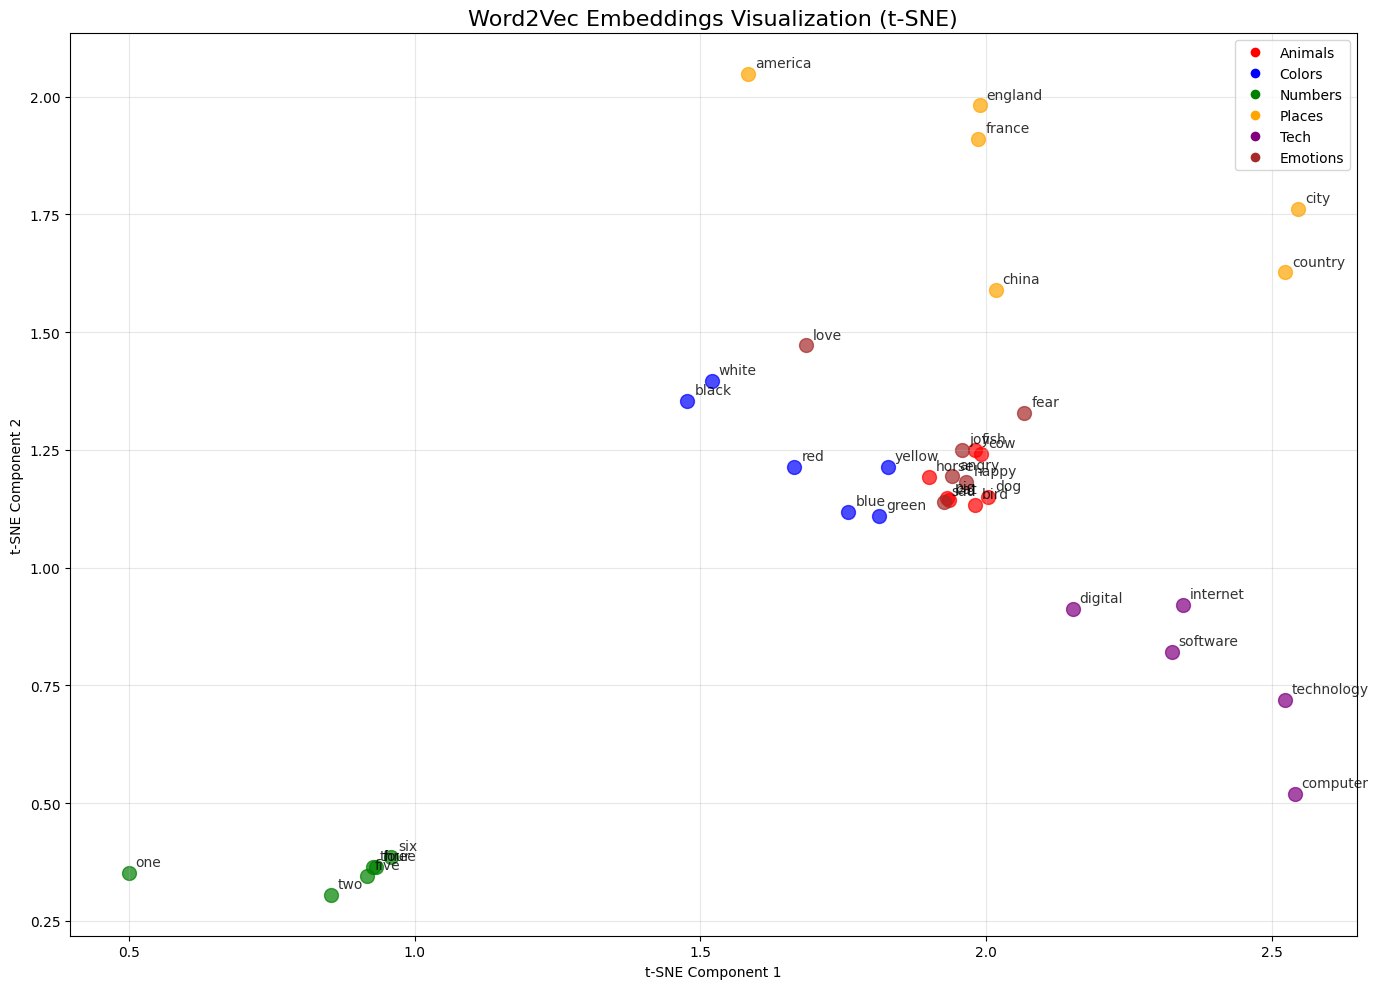


Creating PCA visualization...


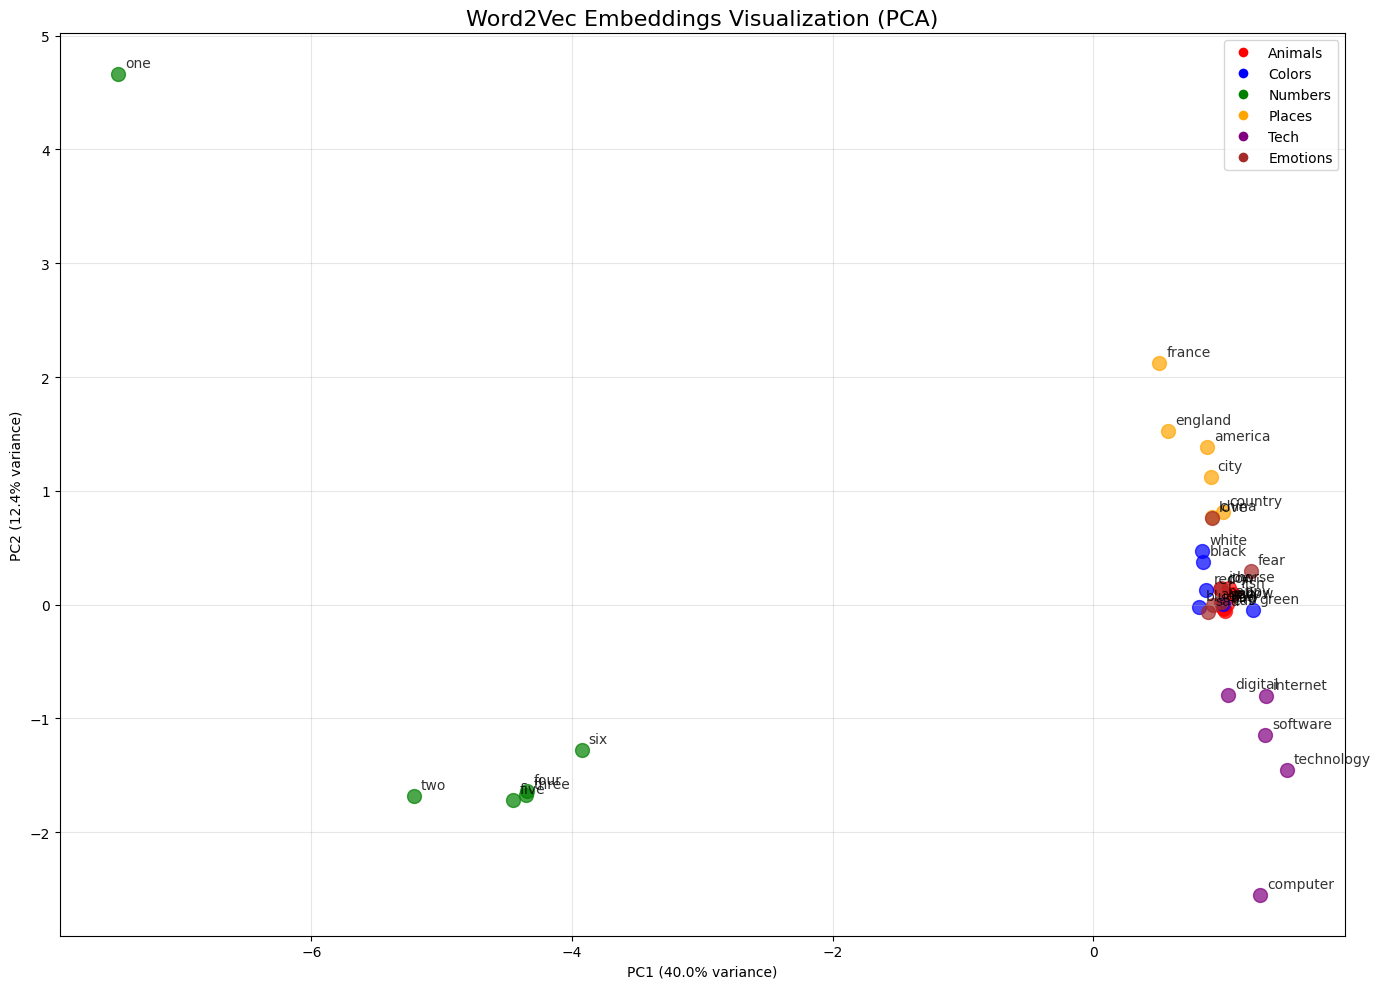

PCA explained variance: PC1=40.0%, PC2=12.4%


In [22]:
print("\n\n3️⃣ EMBEDDING VISUALIZATION")
print("-" * 40)

viz_words = [
    'dog', 'cat', 'bird', 'fish', 'horse', 'cow', 'pig',
    'red', 'blue', 'green', 'yellow', 'black', 'white',
    'one', 'two', 'three', 'four', 'five', 'six',
    'america', 'england', 'france', 'china', 'city', 'country',
    'computer', 'internet', 'digital', 'software', 'technology',
    'happy', 'sad', 'love', 'angry', 'fear', 'joy'
]

viz_words = [word for word in viz_words if word in word_to_index]
print(f"Visualizing {len(viz_words)} words...")

if len(viz_words) > 10:
    viz_embeddings = np.array([embeddings[word_to_index[word]] for word in viz_words])
    
    try:
        print("Computing t-SNE (this may take a moment)...")
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(viz_words)-1))
        embeddings_2d = tsne.fit_transform(viz_embeddings)
        tsne_available = True
    except (NameError, AttributeError):
        print("⚠️ t-SNE not available, skipping t-SNE visualization")
        tsne_available = False
    
    if tsne_available:
        plt.figure(figsize=(14, 10))
        
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
        word_categories = {
            'Animals': ['dog', 'cat', 'bird', 'fish', 'horse', 'cow', 'pig'],
            'Colors': ['red', 'blue', 'green', 'yellow', 'black', 'white'],
            'Numbers': ['one', 'two', 'three', 'four', 'five', 'six'],
            'Places': ['america', 'england', 'france', 'china', 'city', 'country'],
            'Tech': ['computer', 'internet', 'digital', 'software', 'technology'],
            'Emotions': ['happy', 'sad', 'love', 'angry', 'fear', 'joy']
        }
        
        for i, word in enumerate(viz_words):
            x, y = embeddings_2d[i]
            
            color = 'black'
            for cat_name, cat_words in word_categories.items():
                if word in cat_words:
                    cat_index = list(word_categories.keys()).index(cat_name)
                    color = colors[cat_index % len(colors)]
                    break
            
            plt.scatter(x, y, c=color, s=100, alpha=0.7)
            plt.annotate(word, (x, y), xytext=(5, 5), textcoords='offset points', 
                        fontsize=10, alpha=0.8)
        
        plt.title('Word2Vec Embeddings Visualization (t-SNE)', fontsize=16)
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.grid(True, alpha=0.3)
        
        legend_elements = []
        for i, (cat_name, _) in enumerate(word_categories.items()):
            color = colors[i % len(colors)]
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                            markerfacecolor=color, markersize=8, label=cat_name))
        plt.legend(handles=legend_elements, loc='best')
        
        plt.tight_layout()
        plt.show()
        
        try:
            print("\nCreating PCA visualization...")
            pca = PCA(n_components=2)
            embeddings_pca = pca.fit_transform(viz_embeddings)
            
            plt.figure(figsize=(14, 10))
            for i, word in enumerate(viz_words):
                x, y = embeddings_pca[i]
                
                color = 'black'
                for cat_name, cat_words in word_categories.items():
                    if word in cat_words:
                        cat_index = list(word_categories.keys()).index(cat_name)
                        color = colors[cat_index % len(colors)]
                        break
                
                plt.scatter(x, y, c=color, s=100, alpha=0.7)
                plt.annotate(word, (x, y), xytext=(5, 5), textcoords='offset points', 
                            fontsize=10, alpha=0.8)
            
            plt.title('Word2Vec Embeddings Visualization (PCA)', fontsize=16)
            plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
            plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
            plt.grid(True, alpha=0.3)
            plt.legend(handles=legend_elements, loc='best')
            plt.tight_layout()
            plt.show()
            
            print(f"PCA explained variance: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}")
            
        except (NameError, AttributeError):
            print("⚠️ PCA not available, skipping PCA visualization")

else:
    print("Not enough words in vocabulary for visualization")


In [23]:
print("\n\n4️⃣ CLUSTERING ANALYSIS")
print("-" * 40)

n_clusters = 8
cluster_words = [word for word in viz_words if word in word_to_index][:40]

if len(cluster_words) > n_clusters:
    cluster_embeddings = np.array([embeddings[word_to_index[word]] for word in cluster_words])
    
    try:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(cluster_embeddings)
        
        clusters = defaultdict(list)
        for word, label in zip(cluster_words, cluster_labels):
            clusters[label].append(word)
        
        print(f"K-means clustering ({n_clusters} clusters):")
        for cluster_id, words in clusters.items():
            print(f"  Cluster {cluster_id}: {', '.join(words)}")
            
    except (NameError, AttributeError):
        print("⚠️ K-means clustering not available (scikit-learn not installed)")
        print("   Skipping clustering analysis")




4️⃣ CLUSTERING ANALYSIS
----------------------------------------
K-means clustering (8 clusters):
  Cluster 1: dog, cat, bird, fish, horse, cow, pig, red, blue, green, yellow, black, white, france, china, country, internet, digital, software, technology, happy, sad, love, angry, fear, joy
  Cluster 0: one
  Cluster 2: two
  Cluster 4: three, four, five, six
  Cluster 5: america
  Cluster 6: england
  Cluster 7: city
  Cluster 3: computer


In [15]:
print("\n\n5️⃣ EMBEDDING QUALITY METRICS")
print("-" * 40)

def calculate_category_coherence():
    coherence_scores = {}
    
    for category, words in test_categories.items():
        valid_words = [word for word in words if word in word_to_index]
        
        if len(valid_words) < 2:
            continue
            
        category_embeddings = np.array([embeddings[word_to_index[word]] for word in valid_words])
        
        similarities = cosine_similarity(category_embeddings)
        
        n = len(similarities)
        total_sim = np.sum(similarities) - np.trace(similarities)
        avg_similarity = total_sim / (n * (n - 1))
        
        coherence_scores[category] = {
            'avg_similarity': avg_similarity,
            'word_count': len(valid_words),
            'words': valid_words
        }
    
    return coherence_scores

coherence = calculate_category_coherence()
print("Category coherence (how similar words in same category are):")
for category, scores in coherence.items():
    print(f"  {category:12}: {scores['avg_similarity']:.3f} (n={scores['word_count']})")




5️⃣ EMBEDDING QUALITY METRICS
----------------------------------------
Category coherence (how similar words in same category are):
  Animals     : 0.014 (n=5)
  Colors      : 0.263 (n=5)
  Numbers     : 0.687 (n=5)
  Countries   : 0.322 (n=5)
  Emotions    : 0.031 (n=5)
  Tech        : 0.339 (n=5)


In [24]:
print("\n\n6️⃣ DETAILED NEAREST NEIGHBORS")
print("-" * 40)

def analyze_neighborhood(word, radius=0.5):
    """Analyze the neighborhood of a word"""
    if word not in word_to_index:
        return f"'{word}' not in vocabulary"
    
    word_idx = word_to_index[word]
    word_embed = embeddings[word_idx]
    
    similarities = cosine_similarity([word_embed], embeddings)[0]
    
    neighbors = []
    for i, sim in enumerate(similarities):
        if i != word_idx and sim >= radius:
            neighbors.append((index_to_word[i], sim))
    
    neighbors.sort(key=lambda x: x[1], reverse=True)
    
    return {
        'total_neighbors': len(neighbors),
        'top_neighbors': neighbors[:10],
        'similarity_stats': {
            'mean': np.mean([sim for _, sim in neighbors]) if neighbors else 0,
            'std': np.std([sim for _, sim in neighbors]) if neighbors else 0,
            'max': max([sim for _, sim in neighbors]) if neighbors else 0
        }
    }

neighborhood_words = ['computer', 'happy', 'red', 'big', 'king']
print("Neighborhood analysis (words with similarity > 0.4):")

for word in neighborhood_words:
    if word in word_to_index:
        analysis = analyze_neighborhood(word, radius=0.4)
        if isinstance(analysis, dict):
            print(f"\n🏠 {word.upper()}:")
            print(f"   Total neighbors: {analysis['total_neighbors']}")
            print(f"   Average similarity: {analysis['similarity_stats']['mean']:.3f}")
            print(f"   Top neighbors: {', '.join([f'{w}({s:.3f})' for w, s in analysis['top_neighbors'][:5]])}")




6️⃣ DETAILED NEAREST NEIGHBORS
----------------------------------------
Neighborhood analysis (words with similarity > 0.4):

🏠 COMPUTER:
   Total neighbors: 236
   Average similarity: 0.473
   Top neighbors: hewlett(0.789), digital(0.724), apple(0.709), software(0.688), macintosh(0.679)

🏠 HAPPY:
   Total neighbors: 139
   Average similarity: 0.439
   Top neighbors: bustling(0.635), drove(0.612), unfit(0.559), airy(0.523), pyramid(0.519)

🏠 RED:
   Total neighbors: 257
   Average similarity: 0.454
   Top neighbors: black(0.674), caspian(0.661), sea(0.630), hills(0.627), agouti(0.608)

🏠 BIG:
   Total neighbors: 172
   Average similarity: 0.430
   Top neighbors: experiment(0.558), capitalize(0.525), reprinted(0.497), raked(0.496), sample(0.488)

🏠 KING:
   Total neighbors: 290
   Average similarity: 0.469
   Top neighbors: son(0.735), pope(0.712), prince(0.700), iii(0.688), duke(0.682)


In [25]:
print("\n\n7️⃣ INTERACTIVE WORD EXPLORER")
print("-" * 40)

def demo_explorer():
    """Demonstration of word exploration"""
    print("🎮 Word Explorer Demo (showing key examples):")
    
    demos = [
        "king",
        "computer + internet", 
        "big - small",
        "king man queen",
        "happy + good"
    ]
    
    for demo in demos:
        print(f"\n🔍 Demo: {demo}")
        
        if demo == "king":
            similar = find_similar_words_detailed("king", 5)
            if isinstance(similar, list):
                print(f"   Similar to 'king': {', '.join([f'{w}({s:.3f})' for w, s, _ in similar])}")
                
        elif demo == "computer + internet":
            if 'computer' in word_to_index and 'internet' in word_to_index:
                embed1 = embeddings[word_to_index['computer']]
                embed2 = embeddings[word_to_index['internet']]
                result_embed = embed1 + embed2
                
                similarities = cosine_similarity([result_embed], embeddings)[0]
                exclude_indices = {word_to_index['computer'], word_to_index['internet']}
                
                top_indices = []
                for idx in np.argsort(similarities)[::-1]:
                    if idx not in exclude_indices:
                        top_indices.append(idx)
                        if len(top_indices) >= 5:
                            break
                
                results = [(index_to_word[idx], similarities[idx]) for idx in top_indices]
                print(f"   computer + internet → {', '.join([f'{w}({s:.3f})' for w, s in results])}")
            else:
                print("   Some words not in vocabulary")
                
        elif demo == "big - small":
            if 'big' in word_to_index and 'small' in word_to_index:
                embed1 = embeddings[word_to_index['big']]
                embed2 = embeddings[word_to_index['small']]
                result_embed = embed1 - embed2
                
                similarities = cosine_similarity([result_embed], embeddings)[0]
                exclude_indices = {word_to_index['big'], word_to_index['small']}
                
                top_indices = []
                for idx in np.argsort(similarities)[::-1]:
                    if idx not in exclude_indices:
                        top_indices.append(idx)
                        if len(top_indices) >= 5:
                            break
                
                results = [(index_to_word[idx], similarities[idx]) for idx in top_indices]
                print(f"   big - small → {', '.join([f'{w}({s:.3f})' for w, s in results])}")
            else:
                print("   Some words not in vocabulary")
                
        elif demo == "king man queen":
            results = word_analogy("king", "man", "queen", 3)
            if isinstance(results, list):
                print(f"   king - man + queen → {', '.join([f'{w}({s:.3f})' for w, s in results])}")
            else:
                print(f"   {results}")
                
        elif demo == "happy + good":
            if 'happy' in word_to_index and 'good' in word_to_index:
                embed1 = embeddings[word_to_index['happy']]
                embed2 = embeddings[word_to_index['good']]
                result_embed = embed1 + embed2
                
                similarities = cosine_similarity([result_embed], embeddings)[0]
                exclude_indices = {word_to_index['happy'], word_to_index['good']}
                
                top_indices = []
                for idx in np.argsort(similarities)[::-1]:
                    if idx not in exclude_indices:
                        top_indices.append(idx)
                        if len(top_indices) >= 5:
                            break
                
                results = [(index_to_word[idx], similarities[idx]) for idx in top_indices]
                print(f"   happy + good → {', '.join([f'{w}({s:.3f})' for w, s in results])}")
            else:
                print("   Some words not in vocabulary")

demo_explorer()

print(f"\n💡 Interactive explorer function available for custom word exploration!")
print(f"   Use find_similar_words_detailed(), word_analogy(), or analyze_neighborhood() functions")




7️⃣ INTERACTIVE WORD EXPLORER
----------------------------------------
🎮 Word Explorer Demo (showing key examples):

🔍 Demo: king
   Similar to 'king': son(0.735), pope(0.712), prince(0.700), iii(0.688), duke(0.682)

🔍 Demo: computer + internet
   computer + internet → hewlett(0.767), digital(0.721), software(0.720), apache(0.686), server(0.681)

🔍 Demo: big - small
   big - small → nixon(0.474), goff(0.460), dawkins(0.455), smith(0.424), simon(0.424)

🔍 Demo: king man queen
   king - man + queen → duke(0.681), prince(0.666), pope(0.661)

🔍 Demo: happy + good
   happy + good → moral(0.538), how(0.518), therefore(0.517), if(0.490), meaningless(0.485)

💡 Interactive explorer function available for custom word exploration!
   Use find_similar_words_detailed(), word_analogy(), or analyze_neighborhood() functions


In [26]:
print("\n\n8️⃣ SUMMARY REPORT")
print("=" * 50)

if embeddings is not None and vocabulary is not None:
    print(f"📊 Model Performance Summary:")
    print(f"   Vocabulary size: {len(vocabulary):,}")
    print(f"   Embedding dimensions: {best_config.get('embedding_dim', embeddings.shape[1])}")
    if final_contexts_count > 0:
        print(f"   Training examples: {final_contexts_count:,}")
    if avg_loss > 0:
        print(f"   Final loss: {avg_loss:.4f}")
    print(f"   Model parameters: {best_config}")

    print(f"\n🎯 Key Findings:")
    if 'coherence' in locals() and coherence:
        print(f"   Most coherent category: {max(coherence.keys(), key=lambda k: coherence[k]['avg_similarity'])}")
        print(f"   Average category coherence: {np.mean([scores['avg_similarity'] for scores in coherence.values()]):.3f}")
    if 'viz_words' in locals():
        print(f"   Words visualized: {len(viz_words)}")
    
    print(f"\n💡 Next Steps:")
    print(f"   - Try larger embedding dimensions for better quality")
    print(f"   - Experiment with different window sizes")
    print(f"   - Use more training data for better representations")
    print(f"   - Compare with pre-trained embeddings (Word2Vec, GloVe, FastText)")

    print("\n🎉 Comprehensive Analysis Complete!")
    print("🔧 All visualization and analysis functions are now available for exploration!")
else:
    print("❌ Cannot generate summary - embeddings or vocabulary not loaded properly.")
    print("Please ensure the first cell ran successfully and all required files are present.")




8️⃣ SUMMARY REPORT
📊 Model Performance Summary:
   Vocabulary size: 71,290
   Embedding dimensions: 200
   Training examples: 1,000,000
   Final loss: 6.6179
   Model parameters: {'vocab_size': 71290, 'embedding_dim': 200, 'architecture': 'SimpleWord2Vec_CBOW'}

🎯 Key Findings:
   Most coherent category: Numbers
   Average category coherence: 0.276
   Words visualized: 36

💡 Next Steps:
   - Try larger embedding dimensions for better quality
   - Experiment with different window sizes
   - Use more training data for better representations
   - Compare with pre-trained embeddings (Word2Vec, GloVe, FastText)

🎉 Comprehensive Analysis Complete!
🔧 All visualization and analysis functions are now available for exploration!
